### Use autocorrelation to predict mortality with a Unet

We know that spatiotemporal autocorrelation dominates the mortality signal. Unets may be well-suited to learning these patterns.

In [1]:
!pip -q install segmentation-models-pytorch tensorboard
!pip -q install git+https://github.com/s-kganz/xbatcher.git@patch_filter_resample
# Make sure git install worked
import xbatcher
print(xbatcher.__version__)

0.1.dev236+g2e721fc


In [2]:
# Deep learning stuff
import torch
import torchmetrics
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

# Geospatial
import xarray as xr
import rioxarray

# Etc
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import os 

if 'notebooks' in os.getcwd():
    os.chdir("..")

import util

/home/jovyan/ForestLST/util/__init__.py:19: UserWarning: GCloud SDK not found! Module util.gcs will not be loaded.
  warnings.warn("GCloud SDK not found! Module util.gcs will not be loaded.")


In [3]:
# Set up torch device
# If we have gpu available, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.set_default_device(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Prepare dataset

These are rasterized aerial detection surveys at 1 km resolution.

In [4]:
def preprocess_mort(ds):
    year = os.path.basename(ds.encoding["source"])
    year = int(year.replace(".tif", ""))
    return ds.squeeze(drop=True)\
        .drop_vars("spatial_ref")\
        .rename(band_data="mortality")\
        .assign_coords(time=year)

mort = xr.open_dataset("data_working/westmort_1km.nc")["mortality"]
mort

<xarray.DataArray 'mortality' (time: 27, y: 2608, x: 2360)> Size: 665MB
[166181760 values with dtype=float32]
Coordinates:
  * x        (x) float64 19kB -1.39e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y        (y) float64 21kB 6.28e+06 6.279e+06 ... 3.674e+06 3.673e+06
  * time     (time) int64 216B 1997 1998 1999 2000 2001 ... 2020 2021 2022 2023

Set up data pipeline. Here we want 64x64 patches in space, and a time series looking back 5 years. These are important hyperparameters to tune. There's lot of NAs, so only keep patches that are at least 70% valid *in the last time step*.

In [5]:
from torch.utils.data import DataLoader, Dataset

class BatchGenDataset(Dataset):
    def __init__(self, bgen):
        self.bgen = bgen

    def __len__(self):
        return len(self.bgen)

    def __getitem__(self, idx):
        # replace nans with 0 only in X
        patch = torch.tensor(self.bgen[idx].values)
        X = patch[:-1, ...]
        X = torch.nan_to_num(X)
        y = patch[-1, ...]
        return X, y

def patch_filter(ds, batch, prop_valid=0.70):
    # Accept patch if the last time step has too many NaNs.
    nan_mask = ds.isel(**batch).isel(time=-1).isnull().astype(np.float32)
    
    return 1 - nan_mask.mean() >= prop_valid

# Do a temporal split
bgen_train = xbatcher.BatchGenerator(
    mort.sel(time=slice(None, 2014)),
    input_dims=dict(x=64, y=64, time=5),
    input_overlap=dict(x=0, y=0, time=4),
    filter_fn=patch_filter
)
bgen_valid = xbatcher.BatchGenerator(
    mort.sel(time=slice(2014, None)),
    input_dims=dict(x=64, y=64, time=5),
    input_overlap=dict(x=0, y=0, time=4),
    filter_fn=patch_filter
)

train_ds = BatchGenDataset(bgen_train)
valid_ds = BatchGenDataset(bgen_valid)
X, y = train_ds[0]
print("Input size:", X.size())
print("Output size:", y.size())

Input size: torch.Size([4, 64, 64])
Output size: torch.Size([64, 64])


Define model structure.

In [28]:
unet.unet.config

{'encoder_name': 'resnet18',
 'encoder_depth': 5,
 'encoder_weights': None,
 'decoder_use_norm': 'batchnorm',
 'decoder_channels': (256, 128, 64, 32, 16),
 'decoder_attention_type': None,
 'decoder_interpolation': 'nearest',
 'in_channels': 4,
 'classes': 1,
 'activation': None,
 'aux_params': None}

In [32]:
from importlib import reload
reload(util.training)

class UnetModel(pl.LightningModule):
    def __init__(self, in_channels=1, weighted_mse_constant=1):
        super(UnetModel, self).__init__()
        self.train_nrmse = torchmetrics.regression.NormalizedRootMeanSquaredError(normalization="std")
        self.train_r2    = torchmetrics.regression.PearsonCorrCoef()
        self.train_mse   = torchmetrics.regression.MeanSquaredError()
        self.valid_nrmse = torchmetrics.regression.NormalizedRootMeanSquaredError(normalization="std")
        self.valid_r2    = torchmetrics.regression.PearsonCorrCoef()
        self.valid_mse   = torchmetrics.regression.MeanSquaredError()
        self.loss        = util.training.WeightedMSELoss(constant=weighted_mse_constant)

        self.save_hyperparameters()

        self.unet = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=in_channels)
        # Disable grad in the encoder if using pre-trained weights
        if self.unet.config["encoder_weights"] is not None:
            for p in self.unet.encoder.parameters():
                 p.requires_grad = False

        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, X):
        X = self.unet(X)
        X = self.sigmoid(X)
        # Squeeze out channel dim
        X = X.squeeze(1)
        # Rescale from 0-100
        return X*100

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=5, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "valid_loss"}
        
    def _get_loss(self, y, y_hat):
        loss = self.loss(y, y_hat)
        return loss

    def _nan_mask(self, y):
        return ~torch.isnan(y.view(-1))

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)

        mask = self._nan_mask(y)
        y = y.view(-1)[mask]
        y_hat = y_hat.view(-1)[mask]

        loss = self._get_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False)

        self.train_nrmse(y_hat, y)
        self.log("train_nrmse", self.train_nrmse, on_epoch=True, on_step=False)

        self.train_r2(y_hat, y)
        self.log("train_corr", self.train_r2, on_epoch=True, on_step=False)

        self.train_mse(y_hat, y)
        self.log("train_mse", self.train_mse, on_epoch=True, on_step=False)
            
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)

        mask = self._nan_mask(y)
        y = y.view(-1)[mask]
        y_hat = y_hat.view(-1)[mask]

        loss = self._get_loss(y_hat, y)
        self.log("valid_loss", loss, prog_bar=True, on_epoch=True, on_step=False)

        self.valid_nrmse(y_hat, y)
        self.log("valid_nrmse", self.valid_nrmse, on_epoch=True, on_step=False)

        self.valid_r2(y_hat, y)
        self.log("valid_corr", self.valid_r2, on_epoch=True, on_step=False)

        self.valid_mse(y_hat, y)
        self.log("valid_mse", self.valid_mse, on_epoch=True, on_step=False)

    # PL docs indicate that this step is unnecessary, but logs show nonsensical
    # metrics otherwise.
    def on_train_epoch_end(self):
        self.train_nrmse.reset()
        self.train_r2.reset()

    def on_validation_epoch_end(self):
        self.valid_nrmse.reset()
        self.valid_r2.reset()

In [34]:
# Check shape
unet = UnetModel(in_channels=4, weighted_mse_constant=5).to(device)
X, y = train_ds[0]
out = unet(X.unsqueeze(0))
assert(out.shape == y.unsqueeze(0).shape)

Define trainer.

In [35]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=True, generator=torch.Generator(device))
val_loader   = torch.utils.data.DataLoader(valid_ds, batch_size=16, shuffle=False, drop_last=True, generator=torch.Generator(device))
print("Training batches:", len(train_loader))
print("Validation batches:", len(val_loader))

Training batches: 95
Validation batches: 39


In [36]:
import datetime
today = datetime.date.today().strftime("%Y%m%d")
trainer = pl.Trainer(
    default_root_dir=os.path.join("logs", f"{today}_damage_unet_weighted_loss_64x64x5"),
    accelerator="auto",
    devices=1,
    max_epochs=30,
    callbacks=[
        pl.callbacks.EarlyStopping("valid_loss", min_delta=0.1, patience=5),
        pl.callbacks.ModelCheckpoint(),
    ]
)

trainer.fit(unet, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                           | Params | Mode 
-----------------------------------------------------------------------
0 | train_nrmse | NormalizedRootMeanSquaredError | 0      | train
1 | train_r2    | PearsonCorrCoef                | 0      | train
2 | train_mse   | MeanSquaredError               | 0      | train
3 | valid_nrmse | NormalizedRootMeanSquaredError | 0      | train
4 | valid_r2    | PearsonCorrCoef                | 0      | train
5 | valid_mse   | MeanSquaredError               | 0      | train
6 | loss        | WeightedMSELoss                | 0      | train
7 | unet        | Unet                           | 14.3 M | train
8 | sigmoid     | Sigmoid                        | 0      | train
-----------------------------------------------------------------------
3.2 M     Trainable params
11.2 M    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric NormalizedRootMeanSquaredError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric PearsonCorrCoef was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/pri

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Now compare with naive baselines.

In [37]:
def lastobs(X):
    return torch.nan_to_num(X[:, -1, ...])

def timeavg(X):
    return torch.nan_to_num(torch.nanmean(X, dim=1))

def eval_naive_model(loader, metrics, m):
    for X, y in loader:
        y_hat = m(X)

        y_flat = y.view(-1)
        y_hat_flat = y_hat.view(-1)
        
        mask = ~torch.isnan(y_flat)

        y_flat = y_flat[mask]
        y_hat_flat = y_hat_flat[mask]
        for metric in metrics:
            metric.update(y_hat_flat, y_flat)

    return metrics

In [38]:
for label, loader in zip(["train", "valid"], [train_loader, val_loader]):
    for naive_model in [lastobs, timeavg]:
        mse   = torchmetrics.regression.MeanSquaredError()
        corr  = torchmetrics.regression.PearsonCorrCoef()
        nrmse = torchmetrics.regression.NormalizedRootMeanSquaredError(normalization="std")
        eval_naive_model(loader, [mse, corr, nrmse], naive_model)
        trainer.logger.log_metrics({f"{label}_{naive_model.__name__}_loss":mse.compute()})
        trainer.logger.log_metrics({f"{label}_{naive_model.__name__}_corr":corr.compute()})
        trainer.logger.log_metrics({f"{label}_{naive_model.__name__}_nrmse":nrmse.compute()})

Plot metrics

In [39]:
from functools import reduce

versions = os.listdir(os.path.join(trainer.default_root_dir, "lightning_logs"))
latest_version = max(versions, key=lambda x: int(x[-1]))

log = util.training.parse_tensorboard(os.path.join(trainer.default_root_dir, "lightning_logs", latest_version))
dfs = [df.rename(columns=dict(value=key)).drop(columns="wall_time") for key, df in log.items()]
fulldf = reduce(lambda x, y: pd.merge(x, y, on=["step"], how="outer"), dfs)
naive_models = fulldf.iloc[0].dropna()
fulldf = fulldf[~fulldf.train_loss.isna()]

In [40]:
naive_models

step                    0.000000
hp_metric              -1.000000
train_lastobs_loss      1.755558
train_lastobs_corr      0.266779
train_lastobs_nrmse     1.178310
train_timeavg_loss      1.332629
train_timeavg_corr      0.246058
train_timeavg_nrmse     1.027750
valid_lastobs_loss     10.707086
valid_lastobs_corr      0.239017
valid_lastobs_nrmse     1.163069
valid_timeavg_loss      7.598266
valid_timeavg_corr      0.266691
valid_timeavg_nrmse     0.979777
Name: 0, dtype: float64

In [41]:
fulldf.iloc[-1]

step                   1044.000000
hp_metric                      NaN
valid_loss               33.997639
valid_nrmse               1.042786
valid_corr                0.186361
valid_mse                 8.606988
epoch                    10.000000
train_loss                4.711350
train_nrmse               1.227301
train_corr                0.281081
train_mse                 1.902322
train_lastobs_loss             NaN
train_lastobs_corr             NaN
train_lastobs_nrmse            NaN
train_timeavg_loss             NaN
train_timeavg_corr             NaN
train_timeavg_nrmse            NaN
valid_lastobs_loss             NaN
valid_lastobs_corr             NaN
valid_lastobs_nrmse            NaN
valid_timeavg_loss             NaN
valid_timeavg_corr             NaN
valid_timeavg_nrmse            NaN
Name: 22, dtype: float64

array([[<Axes: xlabel='epoch'>, <Axes: xlabel='epoch'>,
        <Axes: xlabel='epoch'>]], dtype=object)

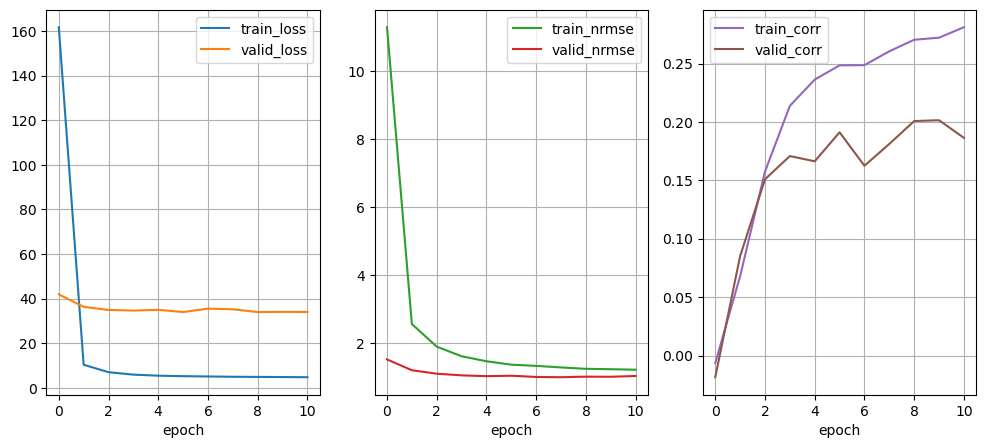

In [42]:
# Plots are easier to read when we ignore the first few epochs
# where the model is just learning the bias
fulldf.plot(
    x="epoch", y=["train_loss", "valid_loss", "train_nrmse", "valid_nrmse", "train_corr", "valid_corr"],
    subplots=[("train_loss", "valid_loss"), ("train_nrmse", "valid_nrmse"), ("train_corr", "valid_corr")],
    layout=(1, 3),
    sharex=True, sharey=False,
    grid=True,
    figsize=(12, 5),
)

Show a 1-to-1 plot

In [21]:
y_hat  = []
y_true = []
unet = unet.to(device)
for X, y in train_loader:
    y_hat.append(unet(X))
    y_true.append(y)

In [22]:
y_hat_flat  = torch.stack(y_hat).view(-1)
y_true_flat = torch.stack(y_true).view(-1)

mask = ~torch.isnan(y_true_flat)

y_hat_nona  = y_hat_flat[mask]
y_true_nona = y_true_flat[mask]

print(y_hat_nona.shape)
print(y_true_nona.shape)

torch.Size([5227491])
torch.Size([5227491])


In [23]:
y_hat_np = y_hat_nona.detach().cpu().numpy()
y_true_np = y_true_nona.detach().cpu().numpy()

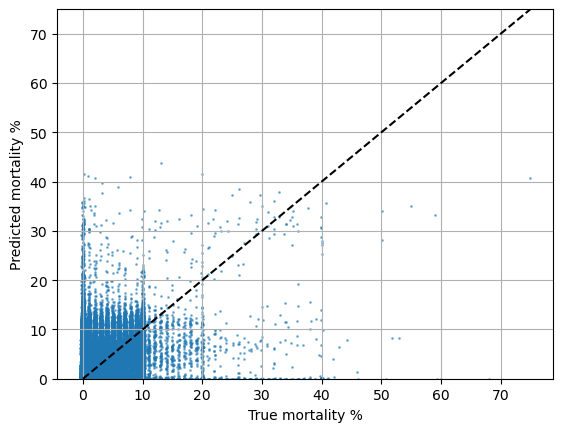

In [25]:
def with_jitter(arr):
    stdev = np.std(arr) * 0.1
    return arr + np.random.randn(*arr.shape)*stdev

plt.grid()
plt.axline(xy1=(0, 0), slope=1, color="black", linestyle="--")
plt.scatter(with_jitter(y_true_np), y_hat_np, s=1, alpha=0.5)
plt.gca().set_ylim(0, 75)
plt.xlabel("True mortality %")
plt.ylabel("Predicted mortality %")
plt.show()